# Processing of AERONET data

In [1]:
import pandas as pd
import numpy as np
import readData2 as rd2
import gdal
import math
import matplotlib.pyplot as plt

## 1. Introduction

*Aerosol Robotic Network (AERONET)* is a ground-based aerosol network which can provide a long-term and readily accessible public domain database of aerosol optical. 

We retrieved AERONET data from Goddard Space Flight Center ([GSFC](https://aeronet.gsfc.nasa.gov)) from NASA. The time range of the dataset is October and November of the year 2019. In the spatial extent we specified, there are 37 AERONET stations. However, a lot of them have been discontinued to function, and some of the functioning stations do not provide up-to-date data for researchers to use. Therefore, as we filtered data with respect to their availability and their location, we selected the following 6 AERONET stations for our AOD groud measurement. 

In [2]:
AERONET_sites = pd.read_csv('AERONET_Sites.csv')
AERONET_sites

,Station Name,level,lon,lat,elevation,website
0,UCSB,1.5,-119.84536,34.41543,33.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...
1,Mount_Wilson,1.5,-118.05590,34.22470,1710.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...
2,Santa_Monica_Colg,1.5,-118.47113,34.01685,55.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...
3,CalTech,2.0,-118.12617,34.13673,260.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...
4,La_Jolla,1.5,-117.25113,32.86846,80.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...
5,TABLE_MOUNTAIN_CA,1.5,-117.68000,34.38000,2200.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...


### Data preprocessing in Microsoft Excel

We gathered raw dataset from the GSFC, and then we use Microsoft Excel to convert the dataset in a form that's convenient to process. We extracted the nearest AERONET observations that are within 30 min around the MODIS local overpass time. We have to note that the timestamps in the AERONET data are based on the GMT Time. 

Since the AERONET AOD measurement do not include the 550 nm channel which our SARA algorithm is based, we need to interpolate the AOD at 550 nm with the Ångstro€m Exponent a440675 nm and AOD at 440 nm and 675 nm channels provided in the AERONET data sets. Ångstro€m Exponent (Ångstro€m, 1964) is used to describe the dependency of the aerosol optical thickness, or aerosol extinction coefficient on wavelength. According to Liu et al., the AOD 550 nm could be interpolated as: 

$
\tau_{550} = \tau_{675} * (\frac{550}{675})^{-\alpha_{440-675nm}}
$

https://deepblue.gsfc.nasa.gov/science

In [3]:
AERONET_CalTech = pd.read_excel('AERONET DATA.xlsx', 'CalTech')
AERONET_CalTech

# Rayleigh Optical Depth
tau_R = 0.09847234720729856

In [4]:
pixels = []
lines = []
observations = []
for row in AERONET_sites.itertuples():
    print(row)
    lon = row._4
    lat = row._3
    pixel, line = rd2.world2Pixel(lat, lon)
    pixels.append(pixel)
    lines.append(line)
    observations.append({
        'name' : row._1,
        'data' : pd.read_excel('AERONET DATA.xlsx', row._1)
    })
    
AERONET_sites['pixel'] = pd.Series(pixels, AERONET_sites.index)
AERONET_sites['line'] = pd.Series(lines, AERONET_sites.index)
AERONET_sites

Pandas(Index=0, _1='UCSB', _2=1.5, _3=-119.84536000000001, _4=34.41543, _5=33.0, _6=' https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=UCSB')
Pandas(Index=1, _1='Mount_Wilson', _2=1.5, _3=-118.0559, _4=34.2247, _5=1710.0, _6=' https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Mount_Wilson')
Pandas(Index=2, _1='Santa_Monica_Colg', _2=1.5, _3=-118.47113, _4=34.01685, _5=55.0, _6=' https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Santa_Monica_Colg')
Pandas(Index=3, _1='CalTech', _2=2.0, _3=-118.12617, _4=34.13673, _5=260.0, _6=' https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=CalTech')
Pandas(Index=4, _1='La_Jolla', _2=1.5, _3=-117.25113, _4=32.86846, _5=80.0, _6=' https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=La_Jolla')
Pandas(Index=5, _1='TABLE_MOUNTAIN_CA', _2=1.5, _3=-117.68, _4=34.38, _5=2200.0, _6=' https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=TABLE_MOUNTAIN_CA')


,Station Name,level,lon,lat,elevation,website,pixel,line
0,UCSB,1.5,-119.84536,34.41543,33.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...,257,130
1,Mount_Wilson,1.5,-118.05590,34.22470,1710.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...,655,172
2,Santa_Monica_Colg,1.5,-118.47113,34.01685,55.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...,563,218
3,CalTech,2.0,-118.12617,34.13673,260.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...,640,192
4,La_Jolla,1.5,-117.25113,32.86846,80.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...,834,474
5,TABLE_MOUNTAIN_CA,1.5,-117.68000,34.38000,2200.0,https://aeronet.gsfc.nasa.gov/cgi-bin/data_di...,739,138


In [5]:
import readData2 as rd2
for dofy in range(298, 310):
    myd03 = rd2.read_myd03(dofy)
    sensorZenith = myd03['SensorZenith'].ReadAsArray()
    solarZenith = myd03['SolarZenith'].ReadAsArray()
    µ_s = np.cos(rd2.to_radian(solarZenith))
    µ_v = np.cos(rd2.to_radian(sensorZenith))
    rd2.matrix_to_geo_tiff('MYD03/µ_s_{:03d}.tif'.format(dofy), µ_s)
    rd2.matrix_to_geo_tiff('MYD03/µ_v_{:03d}.tif'.format(dofy), µ_v)

In [6]:
def collecting_data_for_equation(dofy):
    day_values = []
    for site in AERONET_sites.itertuples():
        aeronet_ob = observations[site.Index]['data']
        aeronet_ob = aeronet_ob.loc[aeronet_ob['Day_of_Year'] == dofy]
        if len(aeronet_ob.AERONET_Site_Name.values) == 0:
            continue
        aeronet_ob = aeronet_ob.AOD550.values[0]
        pixel = site[7]
        line = site[8]
        TOA = gdal.Open('MYD02/TOA_{:03d}.tif'.format(dofy)).ReadAsArray()[line, pixel]
        Ray = gdal.Open('Rayleigh_Reflectance/2019{:03d}.tif'.format(dofy)).ReadAsArray()[line, pixel]
        SurRef = gdal.Open('MYD09_Project/A2019{:03d}_Project_Clipped.tif'.format(dofy)).ReadAsArray()[line, pixel]
        if TOA > 1 or Ray > 1 or SurRef > 1:
            continue
        cos_so_ze = gdal.Open('MYD03/µ_s_{:03d}.tif'.format(dofy)).ReadAsArray()[line, pixel]
        cos_se_ze = gdal.Open('MYD03/µ_v_{:03d}.tif'.format(dofy)).ReadAsArray()[line, pixel]
        P_a = gdal.Open('Rayleigh_Reflectance/P_a_2019{:03d}.tif'.format(dofy)).ReadAsArray()[line, pixel]
        # Rayleigh_Ref = gdal.Open('Rayleigh_Reflectance/2019{:03d}.tif'.format(dofy)).ReadAsArray()[line, pixel]
        day_values.append({
            'aod' : aeronet_ob,
            'TOA' : TOA,
            'SurRef' : SurRef,
            'µ_s': cos_so_ze,
            'µ_v': cos_se_ze,
            'P_a': P_a,
            'Ray': Ray
        })
    return day_values
    


In [52]:
def compute_w_g(data):
    if len(data)<=1:
        return -1, -1, -1
    residuals = np.zeros((101, 101), dtype=np.float64)
    min_res = 1000000000
    min_w = -1
    min_g = -1
    for i100 in range(0, 101): # w
        i = i100/10
        for j100 in range(0,101): # g
            j = j100/100
            residual = 0
            for d in data:
                numerator = math.pow(math.e, (-(d['aod'] + tau_R)/d['µ_s'])) * math.pow(math.e, (-(d['aod'] + tau_R)/d['µ_v'])) * d['SurRef']
                denominator = 1 - d['SurRef'] * (0.92 * tau_R + (1 - j) * d['aod']) * math.pow(math.e, -(tau_R + d['aod']))
                right = 2*d['TOA'] - d['Ray'] - 0.2* numerator / denominator ######
                right = right * 4 * d['µ_s'] * d['µ_v'] / (i * d['P_a'])
                # print(numerator, denominator, right)
                # if right < 0:
                #     residual = residual + 10000
                # residual = residual + (right - d['aod']) * (right - d['aod'])
                residual = residual + abs(right - d['aod'])# * (right - d['aod'])
            #     if residual > min_res:
            #         break
            if residual < min_res:
                min_res = residual
                min_w = i
                min_g = j
            residuals[i100-30, j100] = residual/len(data)
    min_ids = np.argmin(residuals)
    min_res = np.min(residuals)
    # print(residuals)
    plt.imshow(residuals)
    plt.colorbar()
    return min_w, min_g, min_res
        

/Users/weiye/.conda/envs/New37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


[[0.06247223 0.06247293 0.06247364 ... 0.06254116 0.06254186 0.06254256]
 [0.06056757 0.06056825 0.06056893 ... 0.06063428 0.06063495 0.06063563]
 [0.05878195 0.05878261 0.05878327 ... 0.05884657 0.05884723 0.05884788]
 ...
 [0.06903272 0.0690335  0.06903429 ... 0.06910931 0.06911009 0.06911087]
 [0.06668969 0.06669044 0.0666912  ... 0.06676354 0.06676429 0.06676504]
 [0.06450824 0.06450897 0.0645097  ... 0.06457955 0.06458028 0.064581  ]]
7.1 1.0 0.033290608654907905


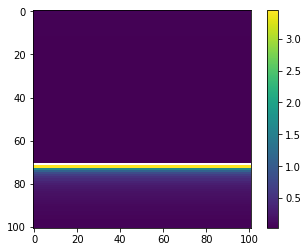

In [53]:
data298 = collecting_data_for_equation(299)
min_w, min_g, min_res = compute_w_g(data298)
print(min_w, min_g, min_res)

/Users/weiye/.conda/envs/New37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


[[0.04299745 0.04299758 0.04299772 ... 0.04301063 0.04301076 0.04301089]
 [0.04076326 0.04076339 0.04076352 ... 0.04077602 0.04077615 0.04077627]
 [0.03866871 0.03866884 0.03866897 ... 0.03868107 0.03868119 0.03868132]
 ...
 [0.05069297 0.05069312 0.05069327 ... 0.05070761 0.05070776 0.05070791]
 [0.04794457 0.04794471 0.04794486 ... 0.04795869 0.04795883 0.04795898]
 [0.04538571 0.04538585 0.04538599 ... 0.04539935 0.04539948 0.04539962]]
6.4 1.0 0.013315260550890681
[[0.06247223 0.06247293 0.06247364 ... 0.06254116 0.06254186 0.06254256]
 [0.06056757 0.06056825 0.06056893 ... 0.06063428 0.06063495 0.06063563]
 [0.05878195 0.05878261 0.05878327 ... 0.05884657 0.05884723 0.05884788]
 ...
 [0.06903272 0.0690335  0.06903429 ... 0.06910931 0.06911009 0.06911087]
 [0.06668969 0.06669044 0.0666912  ... 0.06676354 0.06676429 0.06676504]
 [0.06450824 0.06450897 0.0645097  ... 0.06457955 0.06458028 0.064581  ]]
7.1 1.0 0.033290608654907905
[[0.03515288 0.0351523  0.03515172 ... 0.03509635 0.03

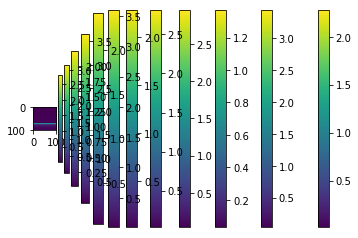

In [54]:
dataset = []
w = []
g = []
for dofy in range(298,310):  
    dataset.append(collecting_data_for_equation(dofy))
    min_w, min_g, min_res = compute_w_g(dataset[dofy-298])
    print(min_w, min_g, min_res)
    w.append(min_w)
    g.append(min_g)
    



1.0 1.0 0.07503899628122565


In [49]:
d = data298[1]
i = min_w
j = min_g
numerator = math.pow(math.e, (-(d['aod'] + tau_R)/d['µ_s'])) * math.pow(math.e, (-(d['aod'] + tau_R)/d['µ_v'])) * d['SurRef']
denominator = 1 - d['SurRef'] * (0.92 * tau_R + (1 - j) * d['aod']) * math.pow(math.e, -(tau_R + d['aod']))
right = 2*d['TOA'] - d['Ray'] - 0.2* numerator / denominator
right = right * 4 * d['µ_s'] * d['µ_v'] / (i * d['P_a'])

print(right, d['aod'])
# print(d['TOA'] - d['Ray'])

0.028704979349108074 0.04056082469371286


In [55]:
np.save('para_g.npy', g)
np.save('para_omega.npy', w)
